In [889]:
import pandas as pd
import numpy as np
import time
from pathlib import Path
import holidays
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def create_Pipeline(num_columns, VAR_num_scaler, le_columns, oh_columns, VAR_regressor):
    le_transformer = FunctionTransformer(
        lambda x: np.array(pd.factorize(x.squeeze())[0]).reshape(-1, 1)
    )
    preprocessor = ColumnTransformer(transformers=[
        ('scaled_num', VAR_num_scaler, num_columns),        # Scaling for numerical columns
        ('le_encoded', le_transformer, le_columns),         # Label encoding for specific columns
        ('oh_encoded', OneHotEncoder(), oh_columns)         # One-hot encoding for categorical columns
    ])
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', VAR_regressor)
    ])
    return pipeline


def fine_tune(pipeline, data, target):
    param_grid = {
        'regressor__n_estimators': [100, 200],
        'regressor__max_depth': [3, 5, 7],
        #'regressor__min_samples_split': [2, 5],
        #'regressor__min_samples_leaf': [1, 2],
        #'regressor__max_features': ['sqrt', 'log2', None],
        #'regressor__bootstrap': [True, False]
    }
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
    grid_search_result = grid_search.fit(data, target, error_score='raise')
    return grid_search_result


def final_output(grid_search_result, test_data):
    y_pred = grid_search_result.predict(test_data)
    results = pd.DataFrame(
        dict(
            Id = np.arange(y_pred.shape[0]),
            log_bike_count=y_pred,
        )
    )
    results.to_csv(f'submission_{grid_search_result}.csv', index=False)

def clean(df, df_name):
    df = df.dropna()
    return df




In [890]:
data = pd.read_parquet(Path('data') / 'train.parquet')
data_meteo = pd.read_csv('external_data/export-paris0.csv')
data_test = pd.read_parquet(Path('data') / 'final_test.parquet')


## Feature extraction

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field:

In [891]:
def _encode_dates_data(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour
    X['isWeekend'] = X['weekday'].apply(lambda x: 1 if x >= 5 else 0)

    vacances = holidays.CountryHoliday('France', years=[i for i in range(2009, 2025)])
    vacances_dates = pd.to_datetime(list(vacances.keys())).date
    X['isHoliday'] = X["date"].isin(vacances_dates).astype(int)

    return X

In [892]:
def _encode_dates_data_meteo(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["DATE"] = pd.to_datetime(X["DATE"])
    X["year"] = X["DATE"].dt.year
    X["month"] = X["DATE"].dt.month
    X["day"] = X["DATE"].dt.day
    X["weekday"] = X["DATE"].dt.weekday
    X["hour"] = X["DATE"].dt.hour
    X['isWeekend'] = X['weekday'].apply(lambda x: 1 if x >= 5 else 0)

    vacances = holidays.CountryHoliday('France', years=[i for i in range(2009, 2025)])
    vacances_dates = pd.to_datetime(list(vacances.keys())).date
    X['isHoliday'] = X["DATE"].isin(vacances_dates).astype(int)
    X = X.drop(columns = ['TEMPERATURE_NIGHT_C', 'SUNRISE', 'SUNSET'] )



    # Finally we can drop the original columns from the dataframe
    return X

In [893]:
_encode_dates_data_meteo(data_meteo)

,DATE,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,TEMPERATURE_MORNING_C,TEMPERATURE_NOON_C,TEMPERATURE_EVENING_C,PRECIP_TOTAL_DAY_MM,HUMIDITY_MAX_PERCENT,VISIBILITY_AVG_KM,...,UV_INDEX,SUNHOUR,OPINION,year,month,day,weekday,hour,isWeekend,isHoliday
0,2009-01-01,4,-2,9,-2,4,-2,0.0,96,7.000,...,1,8.6,météo très défavorable,2009,1,1,3,0,0,1
1,2009-01-02,1,-4,17,-4,1,-2,0.0,84,10.000,...,2,8.6,météo très défavorable,2009,1,2,4,0,0,0
2,2009-01-03,1,-3,17,-3,1,-2,0.0,96,10.000,...,2,8.6,météo très défavorable,2009,1,3,5,0,1,0
3,2009-01-04,-1,-5,6,-5,-1,-4,0.0,69,10.000,...,2,6.9,météo très défavorable,2009,1,4,6,0,1,0
4,2009-01-05,-1,-3,10,-3,-1,-2,5.5,95,6.125,...,2,3.2,météo très défavorable,2009,1,5,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5808,2024-11-26,11,7,15,7,10,9,0.0,75,10.000,...,3,8.0,météo défavorable,2024,11,26,1,0,0,0
5809,2024-11-27,13,10,29,10,12,11,1.1,83,9.875,...,3,1.0,météo défavorable,2024,11,27,2,0,0,0
5810,2024-11-28,9,7,9,7,8,6,0.1,75,10.000,...,2,6.0,météo défavorable,2024,11,28,3,0,0,0
5811,2024-11-29,8,3,15,3,7,6,0.0,80,10.000,...,3,8.0,météo très défavorable,2024,11,29,4,0,0,0


In [894]:
def compile_data(raw_bike_counter_data, raw_data_meteo):

    bike_counter_data = raw_bike_counter_data.copy()
    data_meteo = raw_data_meteo.copy()

    bike_counter_data = clean(bike_counter_data, 'bike_counter_data')
    bike_counter_data = _encode_dates_data(bike_counter_data)

    data_meteo['DATE'] = pd.to_datetime(data_meteo['DATE'])
    print(data_meteo)
    data_meteo = clean(data_meteo, 'data_meteo')
    print(data_meteo)
    data_meteo = _encode_dates_data_meteo(data_meteo)

    merged_data = pd.merge(bike_counter_data, data_meteo, on=['year', 'month', 'day'])

    columns_to_drop = ['date', 'day', 'counter_name', 'site_name', 'DATE', 'counter_installation_date', 'coordinates', 'counter_technical_id', 'latitude', 'longitude']
    if 'bike_count' in merged_data.columns:
        merged_data = merged_data.drop(columns = 'bike_count')
    merged_data = merged_data.drop(columns = columns_to_drop)
    
    return merged_data


In [895]:
data = compile_data(data, data_meteo)
data

           DATE  MAX_TEMPERATURE_C  MIN_TEMPERATURE_C  WINDSPEED_MAX_KMH  \
0    2009-01-01                  4                 -2                  9   
1    2009-01-02                  1                 -4                 17   
2    2009-01-03                  1                 -3                 17   
3    2009-01-04                 -1                 -5                  6   
4    2009-01-05                 -1                 -3                 10   
...         ...                ...                ...                ...   
5808 2024-11-26                 11                  7                 15   
5809 2024-11-27                 13                 10                 29   
5810 2024-11-28                  9                  7                  9   
5811 2024-11-29                  8                  3                 15   
5812 2024-11-30                  9                  3                  6   

      TEMPERATURE_MORNING_C  TEMPERATURE_NOON_C  TEMPERATURE_EVENING_C  \
0            

,counter_id,site_id,log_bike_count,year,month,weekday_x,hour_x,isWeekend_x,isHoliday_x,MAX_TEMPERATURE_C,...,WEATHER_CODE_NOON,WEATHER_CODE_EVENING,TOTAL_SNOW_MM,UV_INDEX,SUNHOUR,OPINION,weekday_y,hour_y,isWeekend_y,isHoliday_y


## Linear model

Let's now construct our first linear model with [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). We use a few helper functions defined in `utils.py` of the starting kit to load the train set.

In [896]:
data = _encode_dates_data(data)
data_test = _encode_dates_data(data_test)
data

KeyError: 'date'

In [ ]:
data

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count,year,month,day,weekday,hour,isWeekend,isHoliday
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,2020,9,1,1,2,0,0
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147,2020,9,1,1,3,0,0
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,2020,9,1,1,4,0,0
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438,2020,9,1,1,15,0,0
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585,2020,9,1,1,18,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929175,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,445.0,2021-09-09 06:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,6.100319,2021,9,9,3,6,0,0
929178,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,145.0,2021-09-09 10:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,4.983607,2021,9,9,3,10,0,0
929181,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,218.0,2021-09-09 15:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,5.389072,2021,9,9,3,15,0,0
929184,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,21.0,2021-09-09 22:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,3.091042,2021,9,9,3,22,0,0


In [ ]:
problem_title = "Bike count prediction"
_target_column_name = "log_bike_count"

def get_train_data():
    df = data.copy()
    df = df.sort_values(["date", "counter_name"])
    y_array = df[_target_column_name].values
    X_df = df.drop([_target_column_name, "bike_count"], axis=1)
    return X_df, y_array

In [ ]:
print(data.columns)
X, y = get_train_data()
X.head(2)

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'bike_count',
       'date', 'counter_installation_date', 'coordinates',
       'counter_technical_id', 'latitude', 'longitude', 'log_bike_count',
       'year', 'month', 'day', 'weekday', 'hour', 'isWeekend', 'isHoliday'],
      dtype='object')


,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,year,month,day,weekday,hour,isWeekend,isHoliday
400125,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,2020,9,1,1,1,0,0
408305,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,2020,9,1,1,1,0,0


and

In [ ]:
y

array([1.60943791, 1.38629436, 0.        , ..., 3.49650756, 2.30258509,
       2.07944154])

Where `y` contains the `log_bike_count` variable. 

To test our baseline estimator, we create a validations set from the training set. Note that, during modeling and exploring the data, we always recommend using cross validation rather than a single train / validation split to evaluate your first results, because this will bring more stability and generalization.

We create the validation set by simply slicing the last 30 days of the training set:

In [ ]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [ ]:
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)

Train: n_samples=456507,  2020-09-01 01:00:00 to 2021-08-10 23:00:00
Valid: n_samples=40320,  2021-08-11 00:00:00 to 2021-09-09 23:00:00


In [ ]:
_encode_dates_data(X_train[["date"]]).columns.tolist()

['date', 'year', 'month', 'day', 'weekday', 'hour', 'isWeekend', 'isHoliday']

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

date_encoder = FunctionTransformer(_encode_dates_data)
date_cols = _encode_dates_data(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "isWeekend", "isHoliday"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates_data at 0x7fd731c12b00>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['date', 'year', 'month',
                                                   'day', 'weekday', 'hour',
                                                   'isWeekend', 'isHoliday']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'isWeekend',
                                                   'isHoliday'])])),
                ('ridge', Ridge())])

We then evaluate this model with the RMSE metric,

In [ ]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}"
)


Train set, RMSE=0.63
Valid set, RMSE=0.73


The model doesn't have enough capacity to generalize on the train set, since we have lots of data with relatively few parameters. However it happened to work somewhat better on the test set. We can compare these results with the baseline predicting the mean value,

In [ ]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_valid, np.full(y_valid.shape, y_valid.mean()), squared=False):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44


which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations (we transform the logarithmic bike counts back to their original unit):

In [ ]:
mask = (
    (X_valid["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_valid["date"] > pd.to_datetime("2021/09/01"))
    & (X_valid["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_valid.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_valid[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_valid[mask])) - 1

Text(0, 0.5, 'bike_count')

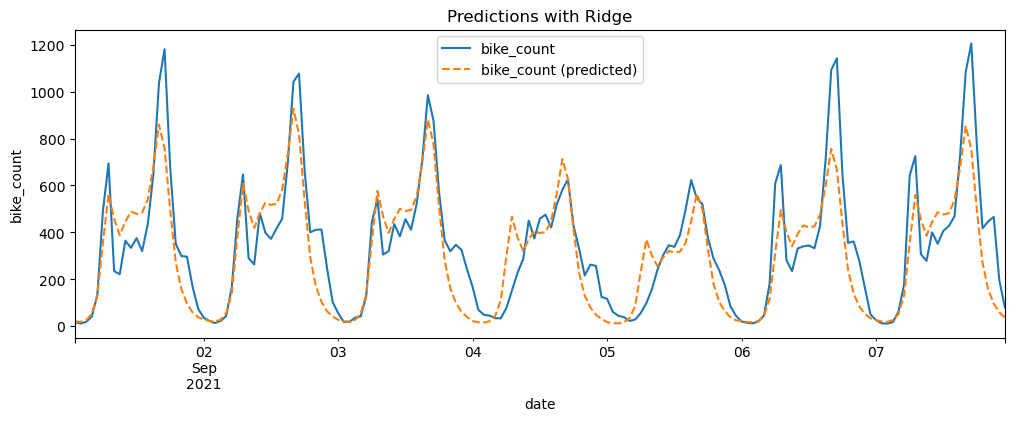

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.96451941 -0.87405183 -0.85117685 -0.8742601  -1.06293286 -0.9657774 ]
RMSE (all folds): 0.932 ± 0.0737


# Final test

In [ ]:
def final_output(model, test_data):
    y_pred = model.predict(test_data)
    results = pd.DataFrame(
        dict(
            Id = np.arange(y_pred.shape[0]),
            log_bike_count=y_pred,
        )
    )
    results.to_csv(f'submission.csv', index=False)

In [ ]:
final_output(pipe, data_test)